# Toy Data: 8-Modes Mixture Model

In [31]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.optim
from time import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom

import data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
ndim_tot = 16
ndim_x = 2
ndim_y = 4
ndim_z = 2

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                         nn.Linear(512,  c_out))

nodes = [InputNode(ndim_tot, name='input')]

for k in range(8):
    nodes.append(Node(nodes[-1],
                      GLOWCouplingBlock,
                      {'subnet_constructor':subnet_fc, 'clamp':2.0},
                      name=F'coupling_{k}'))
    nodes.append(Node(nodes[-1],
                      PermuteRandom,
                      {'seed':k},
                      name=F'permute_{k}'))

nodes.append(OutputNode(nodes[-1], name='output'))

model = ReversibleGraphNet(nodes, verbose=False)
#model.load_state_dict(torch.load('fig_8_UL_INN.pt'))


<IPython.core.display.Javascript object>


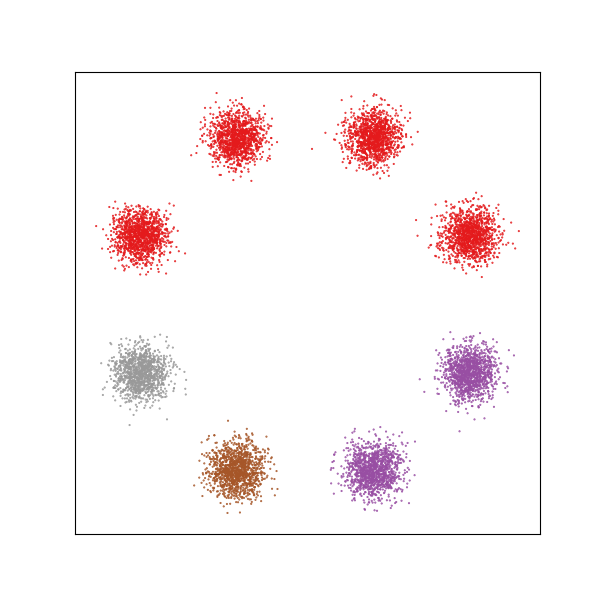

In [33]:
test_split = 10000

pos, labels = data.generate(
    labels='some',
    tot_dataset_size=2**20
)
labels = labels[:,:ndim_y]
c = np.where(labels[:test_split])[1]
plt.figure(figsize=(6, 6))
plt.scatter(pos[:test_split, 0], pos[:test_split, 1], c=c, cmap='Set1', s=0.25)
plt.xticks([])
plt.yticks([])
plt.show()

In [34]:
# Training parameters
n_epochs = 200
n_its_per_epoch = 8
batch_size = 1600

lr = 1e-3
l2_reg = 2e-4

y_noise_scale = 1e-4
zeros_noise_scale = 1e-4
z_noise_scale = 1e-2

# relative weighting of losses:
lambd_predict = 15.
lambd_latent = 300.
lambd_rev = 300.
lambd_recon = 4.
loss_ramp = True


trainable_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=lr, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=l2_reg)


def MMD_multiscale(x, y):
    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2.*xx
    dyy = ry.t() + ry - 2.*yy
    dxy = rx.t() + ry - 2.*zz

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for a in [0.05, 0.2, 0.9]:
        XX += a**2 * (a**2 + dxx)**-1
        YY += a**2 * (a**2 + dyy)**-1
        XY += a**2 * (a**2 + dxy)**-1

    return torch.mean(XX + YY - 2.*XY)


def fit(input, target):
    return torch.mean((input - target)**2)

loss_backward = MMD_multiscale
loss_latent = MMD_multiscale
loss_fit = fit

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[:test_split], labels[:test_split]),
    batch_size=batch_size, shuffle=True, drop_last=True)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(pos[test_split:], labels[test_split:]),
    batch_size=batch_size, shuffle=True, drop_last=True)

In [35]:
def train(i_epoch=0):
    model.train()

    l_tot = 0
    batch_idx = 0
        
    # If MMD on x-space is present from the start, the model can get stuck.
    # Instead, ramp it up exponetially.  
    if loss_ramp:
        loss_factor = min(1., 2. * 0.002**(1. - (float(i_epoch) / n_epochs)))
    else: 
        loss_factor = 1.
    for x, y in train_loader:
        batch_idx += 1
        if batch_idx > n_its_per_epoch:
            break

        x, y = x.to(device), y.to(device)
        
        y_clean = y.clone()
        pad_x = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                ndim_x, device=device)
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)

        y += y_noise_scale * torch.randn(batch_size, ndim_y, dtype=torch.float, device=device)

        x, y = (torch.cat((x, pad_x),  dim=1),
                torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz, y),
                          dim=1))
        

        optimizer.zero_grad()

        # Forward step:

        output = model(x)

        # Shorten output, and remove gradients wrt y, for latent loss
        y_short = torch.cat((y[:, :ndim_z], y[:, -ndim_y:]), dim=1)

        l = lambd_recon * loss_fit(output[:, ndim_z:], y[:, ndim_z:])

        output_block_grad = torch.cat((output[:, :ndim_z],
                                       output[:, -ndim_y:].data), dim=1)

        l += lambd_latent * loss_latent(output_block_grad, y_short)
        l_tot += l.data.item()

        l.backward()

        # Backward step:
        pad_yz = zeros_noise_scale * torch.randn(batch_size, ndim_tot -
                                                 ndim_y - ndim_z, device=device)
        y = y_clean + y_noise_scale * torch.randn(batch_size, ndim_y, device=device)

        orig_z_perturbed = (output.data[:, :ndim_z] + z_noise_scale *
                            torch.randn(batch_size, ndim_z, device=device))
        y_rev = torch.cat((orig_z_perturbed, pad_yz,
                           output.data[:,-ndim_y:]+y_noise_scale *
                            torch.randn(batch_size, ndim_y, device=device)), dim=1)
        y_rev_rand = torch.cat((torch.randn(batch_size, ndim_z, device=device), pad_yz,
                                y), dim=1)
        
        output_rev = model(y_rev, rev=True)
        output_rev_rand = model(y_rev_rand, rev=True)

        l_rev = (
            lambd_rev
            * loss_factor
            * loss_backward(output_rev_rand[:, :ndim_x],
                            x[:, :ndim_x])
        )

        l_rev += lambd_predict * loss_fit(output_rev, x)
        
        l_tot += l_rev.data.item()
        l_rev.backward()

        for p in model.parameters():
            p.grad.data.clamp_(-15.00, 15.00)

        optimizer.step()

    return l_tot / batch_idx

<IPython.core.display.Javascript object>


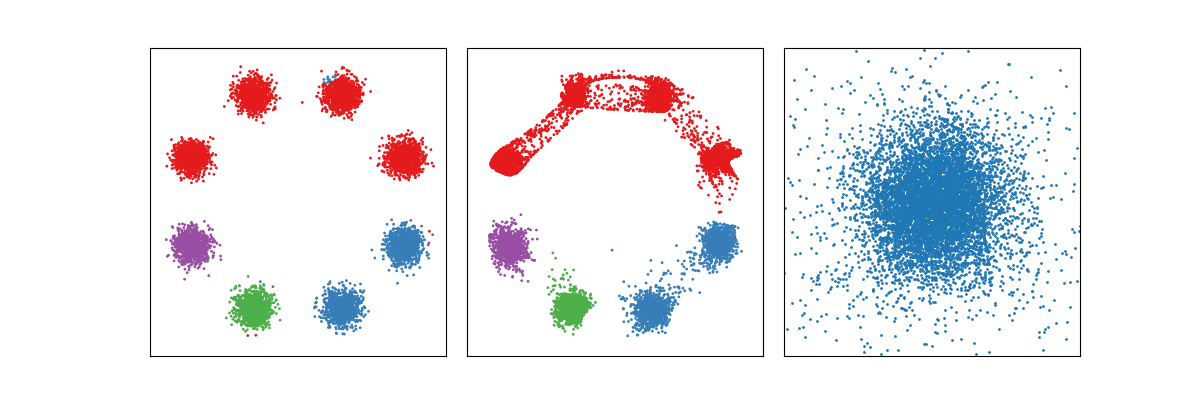

100%|#########################################| 200/200 [10:03<00:00,  3.02s/it]



Training took 10.05 minutes



In [36]:
for param in trainable_parameters:
    param.data = 0.06*torch.randn_like(param)
            
model.to(device)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.07, hspace=.07)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 8096

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
y_samps += 0 * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)

        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, -ndim_y:].argmax(dim=1)

        z_val = model(torch.cat((x_samps, torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))
        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3.5,3.5,-3.5,3.5])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3.5,3.5,-3.5,3.5])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:,0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        axes[2].axis([-4,4,-4,4])
        axes[2].set_xticks([])
        axes[2].set_yticks([])
        
        #plt.savefig('UL.png', bbox_inches = 'tight')

        
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

In [37]:
n_epochs = 400
lambd_predict = 10.
lambd_latent = 150.
lambd_rev = 600.
loss_ramp = False

lr = 6e-4
l2_reg = 1e-7


for g in optimizer.param_groups:
    g['lr'] = lr
    g['weight_decay'] = l2_reg 

<IPython.core.display.Javascript object>


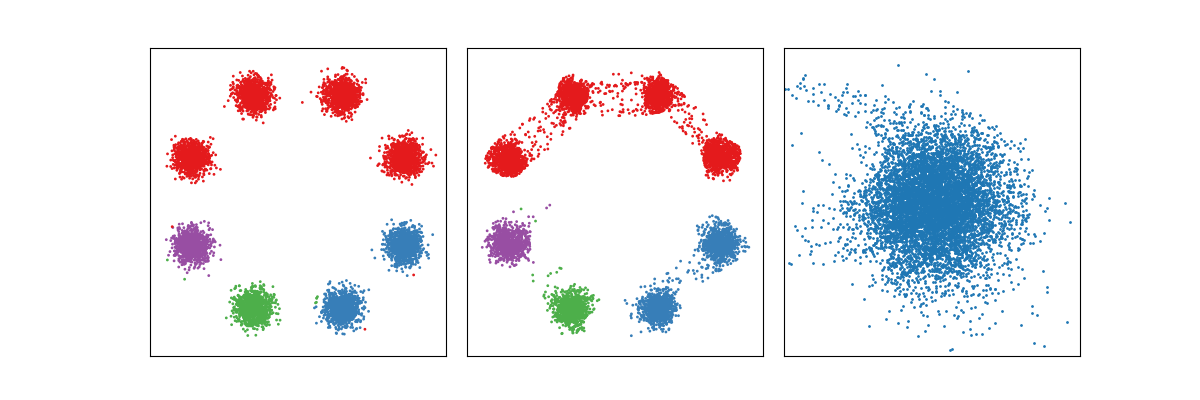

100%|#########################################| 400/400 [17:54<00:00,  2.69s/it]



Training took 17.92 minutes



In [38]:
model.to(device)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.07, hspace=.07)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 8096

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
y_samps += 0 * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)

        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, -ndim_y:].argmax(dim=1)
        
        z_val = model(torch.cat((x_samps, torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))

        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3.5,3.5,-3.5,3.5])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3.5,3.5,-3.5,3.5])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:,0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        axes[2].axis([-4,4,-4,4])
        axes[2].set_xticks([])
        axes[2].set_yticks([])
        
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")

In [41]:
n_epochs = 200
lambd_predict = 10.
lambd_latent = 150.
lambd_rev = 600.
loss_ramp = False

lr = 1e-4
l2_reg = 0.


for g in optimizer.param_groups:
    g['lr'] = lr
    g['weight_decay'] = l2_reg 

<IPython.core.display.Javascript object>


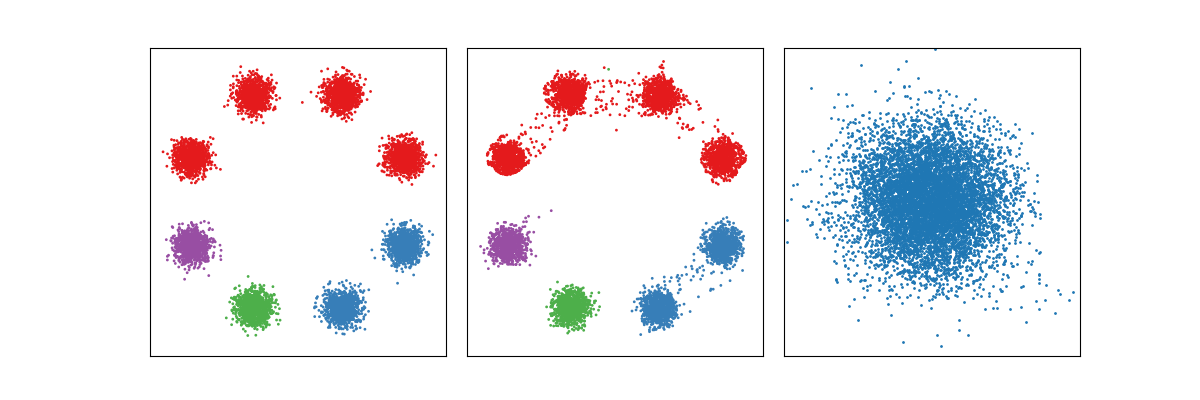

100%|#########################################| 200/200 [07:42<00:00,  2.31s/it]



Training took 7.70 minutes



In [42]:
model.to(device)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.07, hspace=.07)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Predicted labels (Forwards Process)')
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Generated Samples (Backwards Process)')
fig.show()
fig.canvas.draw()

N_samp = 8096

x_samps = torch.cat([x for x,y in test_loader], dim=0)[:N_samp]
y_samps = torch.cat([y for x,y in test_loader], dim=0)[:N_samp]
c = np.where(y_samps)[1]
y_samps += 0 * torch.randn(N_samp, ndim_y)
y_samps = torch.cat([torch.randn(N_samp, ndim_z),
                     zeros_noise_scale * torch.zeros(N_samp, ndim_tot - ndim_y - ndim_z), 
                     y_samps], dim=1)
y_samps = y_samps.to(device)
            
try:
    t_start = time()
    for i_epoch in tqdm(range(n_epochs), ascii=True, ncols=80):

        train(i_epoch)

        rev_x = model(y_samps, rev=True)
        rev_x = rev_x.cpu().data.numpy()
        
        pred_c = model(torch.cat((x_samps, torch.zeros(N_samp, ndim_tot - ndim_x)),
                                 dim=1).to(device)).data[:, -ndim_y:].argmax(dim=1)
        
        z_val = model(torch.cat((x_samps, torch.zeros(len(x_samps), ndim_tot - ndim_x)),
                                 dim=1).to(device))

        axes[0].clear()
        axes[0].scatter(x_samps.cpu()[:,0], x_samps.cpu()[:,1], c=pred_c.cpu(), cmap='Set1', s=1., vmin=0, vmax=9)
        axes[0].axis('equal')
        axes[0].axis([-3.5,3.5,-3.5,3.5])
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].clear()
        axes[1].scatter(rev_x[:,0], rev_x[:,1], c=c, cmap='Set1', s=1., vmin=0, vmax=9)
        axes[1].axis('equal')
        axes[1].axis([-3.5,3.5,-3.5,3.5])
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        
        axes[2].clear()
        axes[2].scatter(z_val.cpu().detach().numpy()[:,0], z_val.cpu().detach().numpy()[:,1],s=1., vmin=0, vmax=9)
        axes[2].axis('equal')
        axes[2].axis([-4,4,-4,4])
        axes[2].set_xticks([])
        axes[2].set_yticks([])
      
        
        if i_epoch == n_epochs-1:
        
            plt.savefig('UL.png', bbox_inches = 'tight')
        
        fig.canvas.draw()


except KeyboardInterrupt:
    pass
finally:
    print(f"\n\nTraining took {(time()-t_start)/60:.2f} minutes\n")